这个文件用来训练Segmentation模型

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from utils import *
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torch.utils import tensorboard as tb

In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(anchor_generator=AnchorGenerator(sizes=((2, 4, 8, 16, 32),), aspect_ratios=((0.5, 1.0, 2.0, 4.0, 8.0),)))
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [3]:
# 加载预训练的Faster R-CNN模型
from torchvision.models.detection import *
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# 获取分类器的输入特征数
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 替换预训练的头部为一个新的，只有两个类别（背景和单词）
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)

In [4]:
class ModifiedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.trans = transforms.Normalize(mean=(0.5), std=(0.5))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img -= img.mean()
        img /= img.std()
        # img = self.trans(img)

        # 将 (x, y, w, h) 格式的边界框转换为 (x1, y1, x2, y2) 格式
        label[:, 2] = label[:, 0] + label[:, 2]
        label[:, 3] = label[:, 1] + label[:, 3]

        # 仅保留包含单词的边界框
        indices = label.sum(dim=-1) > 0
        label = label[indices]

        # 制造classifier的标签
        temp = torch.ones(len(label), dtype=torch.long)
        label = {'boxes': label, 'labels': temp}
        
        return img, label


from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # 使用默认的 collate 处理图片（因为图片大小相同）
    images = default_collate(images)
    
    # 不尝试合并 targets，因为它们包含不同数量的边界框
    # 直接作为列表返回
    return images, targets

In [5]:
# dataset = ModifiedDataset(SegDataset('IAM', 'train'))
dataset = SegDatasetNew('IAM', 'train')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn, drop_last=True)

In [6]:
def get_model_name(epoch):
    return f"fasterrcnn_{epoch}.pth"

writer = tb.SummaryWriter('/root/tf-logs')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 优化器
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 训练模式
model.train()

num_epochs = 100

for epoch in range(num_epochs):
    for step, (images, targets) in enumerate(dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 计算损失
        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        # 反向传播
        optimizer.zero_grad()
        losses.backward()
        # 添加梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        print(f"Epoch {epoch} step {step} loss: {losses.item()} box: {loss_dict['loss_box_reg'].item()} "
              f"obj: {loss_dict['loss_objectness'].item()} rpn: {loss_dict['loss_rpn_box_reg'].item()}")
        writer.add_scalar('Loss/Total', losses.item(), epoch * len(dataloader) + step)
        writer.add_scalar('Loss/Box', loss_dict['loss_box_reg'].item(), epoch * len(dataloader) + step)
        writer.add_scalar('Loss/Objectness', loss_dict['loss_objectness'].item(), epoch * len(dataloader) + step)
        writer.add_scalar('Loss/RPN', loss_dict['loss_rpn_box_reg'].item(), epoch * len(dataloader) + step)
        writer.add_scalar('Loss/Classifier', loss_dict['loss_classifier'].item(), epoch * len(dataloader) + step)

    print(f"Epoch {epoch} loss: {losses.item()}")
    model_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/Faster_R_CNN/'
    model_name = model_path + get_model_name(epoch)
    torch.save(model.state_dict(), model_name)


Epoch 0 step 0 loss: 6.387094497680664 box: 0.2891330122947693 obj: 4.7036848068237305 rpn: 0.8834609985351562
Epoch 0 step 1 loss: 6.265091419219971 box: 0.25912922620773315 obj: 4.566943168640137 rpn: 0.9302946329116821
Epoch 0 step 2 loss: 6.3490095138549805 box: 0.2604210674762726 obj: 4.682990074157715 rpn: 0.8994876742362976
Epoch 0 step 3 loss: 6.358412265777588 box: 0.2697332501411438 obj: 4.698195457458496 rpn: 0.8859900236129761
Epoch 0 step 4 loss: 6.1833648681640625 box: 0.25582605600357056 obj: 4.534955978393555 rpn: 0.893779993057251
Epoch 0 step 5 loss: 5.855408191680908 box: 0.2654803991317749 obj: 4.178134918212891 rpn: 0.9084931015968323
Epoch 0 step 6 loss: 6.03331184387207 box: 0.27847954630851746 obj: 4.3185858726501465 rpn: 0.9323461055755615
Epoch 0 step 7 loss: 5.960406303405762 box: 0.27757731080055237 obj: 4.271395683288574 rpn: 0.9171726703643799
Epoch 0 step 8 loss: 6.049494743347168 box: 0.24604399502277374 obj: 4.391816139221191 rpn: 0.912426233291626
Epoc

出图

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from utils import *

def get_model_name(epoch):
    return f"fasterrcnn_{epoch}.pth"

def load_model(model, epoch):
    model_path = '/root/autodl-tmp/APS360_Project/Machine_Learning_Output/Faster_R_CNN/'
    model_name = model_path + get_model_name(epoch)
    model.load_state_dict(torch.load(model_name))
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_crv = []
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)
model.to(device)

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = default_collate(images)
    return images, targets

dataset = ModifiedDataset(SegDataset('IAM', 'train'))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

for epoch in range(100):
    model = load_model(model, epoch)
    # model.eval()
    total_loss = 0
    total_step = 0
    with torch.no_grad():
        for step, (images, targets) in enumerate(dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 计算损失
            loss_dict = model(images, targets)
            # print(loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            total_step += 1

            # print(f"Epoch {epoch} step {step} loss: {losses.item()}")
    losses = total_loss / total_step
    loss_crv.append(losses)
    print(f"Epoch {epoch} loss: {losses}")

plt.plot(np.arange(len(loss_crv)), loss_crv)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Current Faster R-CNN Model')
plt.show()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0 loss: 1.4299521843592327
Epoch 1 loss: 2.4078004482464914
Epoch 2 loss: 2.5131293076735277
Epoch 3 loss: 2.5633106353955393
Epoch 4 loss: 2.763592799504598
Epoch 5 loss: 2.939693114696405
Epoch 6 loss: 3.227608858010708
Epoch 7 loss: 3.3041126911456766
Epoch 8 loss: 3.5120299596052904
Epoch 9 loss: 3.5352905652461906
Epoch 10 loss: 3.7562476304861216
Epoch 11 loss: 3.9067625999450684
Epoch 12 loss: 4.062150319417317
Epoch 13 loss: 4.202261386773525
Epoch 14 loss: 4.46792625158261
Epoch 15 loss: 4.469106111771021
Epoch 16 loss: 4.6693345461136255
Epoch 17 loss: 4.8165292250804415
Epoch 18 loss: 4.764869677714812
Epoch 19 loss: 4.821755507053473
Epoch 20 loss: 4.889397242130378
Epoch 21 loss: 4.950071909488776
Epoch 22 loss: 5.171686343657664
Epoch 23 loss: 5.0569125933524885
Epoch 24 loss: 5.0835376763955145
Epoch 25 loss: 5.169943540524214
Epoch 26 loss: 5.093042716001853
Epoch 27 loss: 5.516045704866067
Epoch 28 loss: 5.399636525374192
Epoch 29 loss: 5.571760752262214
Epoch 30

In [ ]:
# save loss crv
import pickle
with open('train_crv.pkl', 'wb') as f:
    pickle.dump(loss_crv, f)

In [ ]:
# validation crv

dataset = ModifiedDataset(SegDataset('IAM', 'val'))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_crv = []
for epoch in range(100):
    model = load_model(model, epoch)
    # model.eval()
    total_loss = 0
    total_step = 0
    with torch.no_grad():
        for step, (images, targets) in enumerate(dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 计算损失
            loss_dict = model(images, targets)
            # print(loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
            total_step += 1

            # print(f"Epoch {epoch} step {step} loss: {losses.item()}")
    losses = total_loss / total_step
    val_crv.append(losses)
    print(f"Epoch {epoch} loss: {losses}")

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0 loss: 2.3937403678894045
Epoch 1 loss: 1.4132689952850341
Epoch 2 loss: 0.9501038670539856
Epoch 3 loss: 0.6789250016212464
Epoch 4 loss: 0.528100597858429
Epoch 5 loss: 0.4638660132884979
Epoch 6 loss: 0.4135788559913635
Epoch 7 loss: 0.3777868807315826
Epoch 8 loss: 0.36378070116043093
Epoch 9 loss: 0.3573130011558533
Epoch 10 loss: 0.3569773077964783
Epoch 11 loss: 0.38963437676429746
Epoch 12 loss: 0.390592485666275
Epoch 13 loss: 0.36112846732139586
Epoch 14 loss: 0.3532510221004486
Epoch 15 loss: 0.4232593238353729
Epoch 16 loss: 0.40438262224197385
Epoch 17 loss: 0.372318035364151
Epoch 18 loss: 0.3623042583465576
Epoch 19 loss: 0.3534569501876831
Epoch 20 loss: 0.4087063312530518
Epoch 21 loss: 0.33974774479866027
Epoch 22 loss: 0.3365471661090851
Epoch 23 loss: 0.3191616714000702
Epoch 24 loss: 0.29890450835227966
Epoch 25 loss: 0.3506736636161804
Epoch 26 loss: 0.3467234969139099
Epoch 27 loss: 0.317995685338974
Epoch 28 loss: 0.3178845465183258
Epoch 29 loss: 0.29660

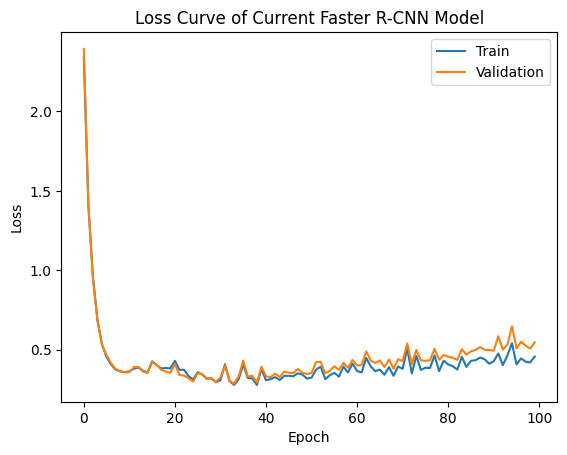

In [ ]:
# plot both crv
plt.plot(np.arange(len(loss_crv)), loss_crv, label='Train')
plt.plot(np.arange(len(val_crv)), val_crv, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Current Faster R-CNN Model')
plt.legend()
plt.show()